In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from   sklearn.decomposition import IncrementalPCA, KernelPCA, PCA
from   sklearn.linear_model import LogisticRegression
from   sklearn.model_selection import GridSearchCV
from   sklearn.pipeline import Pipeline

%matplotlib inline

### Make some highly-correlated data

In [2]:
n_cols = 50
n_rows = 500

X = pd.DataFrame(data=np.zeros([n_rows, n_cols]), 
                 columns=[f'x{i + 1}' for i in range(n_cols)])

In [3]:
X.x1 = np.random.uniform(size=n_rows)
for c in range(2, n_cols + 1):
    intercept = np.random.uniform(-10, 10, size=1)
    slope = np.random.uniform(-3, 3, 1)
    noise = np.random.normal(
        scale=np.random.uniform(0.01, np.abs(slope), n_rows))
    c2 = np.random.choice(range(1, c))
    X[f'x{c}'] = intercept + slope * X[f'x{c2}'] + noise

In [4]:
X.head()

,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,...,x41,x42,x43,x44,x45,x46,x47,x48,x49,x50
0,0.837094,-3.120181,9.816461,4.159235,11.811405,22.272108,-19.164694,18.848765,10.582789,32.597206,...,-12.206787,-46.247946,135.524622,47.681811,-0.668867,-2.669925,-11.438041,28.465796,181.692659,-274.327374
1,0.116409,-2.874234,9.561101,3.329488,11.224593,20.159731,-16.542951,15.983409,10.361607,28.603283,...,-13.775484,-47.688496,140.564690,47.538607,-1.517538,-0.830949,-12.187985,26.280327,163.650748,-246.072861
2,0.470606,-2.615497,9.776808,2.786051,12.297530,27.300324,-24.384467,25.028505,10.570306,39.273030,...,-14.125285,-57.955459,169.310404,48.595119,-1.239382,-3.000423,-12.479067,30.728705,225.390766,-342.757420
3,0.721263,-4.624237,9.820764,3.466076,11.675928,22.934599,-19.425866,20.180282,10.927898,33.280468,...,-14.969452,-52.089065,151.934326,44.696061,-0.290423,-3.514053,-11.392942,27.702217,187.043653,-283.120444
4,0.724899,-1.934100,9.880730,4.877769,13.726438,23.105075,-20.255378,20.215752,11.508087,31.394738,...,-12.662791,-49.080796,143.217681,46.911070,-1.110493,-3.478767,-13.154336,33.929255,177.842026,-268.071625


In [5]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [6]:
# variance explained by each of the first 2 PCs
pca.explained_variance_ratio_ 

array([0.86914159, 0.03636881])

In [7]:
pca = PCA()
pca.fit(X)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

5

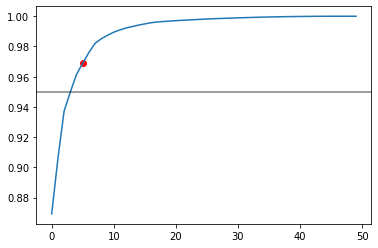

In [8]:
plt.plot(cumsum);
plt.axhline(0.95, c='k', alpha=0.5)
plt.scatter(d, cumsum[d], c='r');

In [9]:
pca = PCA(n_components=0.95)
X_red = pca.fit_transform(X)

In [10]:
X_red.shape

(500, 5)

In [11]:
X_recovered = pca.inverse_transform(X_red)
pd.DataFrame(X_recovered).head()

,0,1,2,3,4,5,6,7,8,9,...,40,41,42,43,44,45,46,47,48,49
0,0.509618,-2.590402,9.773067,4.080876,11.564680,22.108389,-18.840613,18.629033,10.478203,32.064092,...,-14.876618,-46.236577,135.727801,47.716133,-0.594395,-2.441169,-12.064800,27.618959,182.025429,-274.668079
1,0.590322,-2.521501,9.777557,3.953061,11.128293,21.088974,-18.022631,17.657272,10.228782,29.195870,...,-14.712232,-47.403169,139.686279,47.409369,-1.354542,-2.766010,-12.212018,26.170896,162.968401,-245.256072
2,0.562157,-2.654051,9.808921,4.002433,11.624619,27.710066,-25.127884,25.760939,10.473177,39.953962,...,-14.853934,-57.938837,168.379017,48.580876,-1.090225,-2.799718,-12.208477,27.362531,225.033053,-341.056752
3,0.543774,-2.608334,9.777270,4.050856,11.164357,23.566246,-20.608584,20.614538,10.200193,33.369015,...,-14.808627,-51.497211,151.028973,44.653790,-0.428012,-2.515540,-12.109040,26.666505,186.827752,-281.935384
4,0.599342,-2.637283,9.786200,4.033482,12.500533,22.415206,-19.368188,19.314077,11.184935,31.655894,...,-14.722791,-48.983376,143.985971,47.172833,-0.953863,-2.849531,-12.050985,30.363615,177.735777,-268.007669


In [12]:
# us. faster if m or n > ~500
rnd_pca = PCA(n_components=25, svd_solver='randomized') 
X_red = rnd_pca.fit_transform(X)

### Incremental PCA

In [16]:
N_BATCHES = 5
inc_pca = IncrementalPCA(n_components=20)

for X_batch in np.array_split(X, N_BATCHES):
    inc_pca.partial_fit(X_batch)
    
X_reducesd = inc_pca.transform(X)

In [17]:
# Alternately
#X_mn = np.memmap(
#    filename, dtype='float32', mode='readonly', shape=(m, n))
#BATCH_SIZE = m // N_BATCHES
#inc_pca = IncrementalPCA(n_components=20, batch_size=BATCH_SIZE)
#inc_pca.fit(X_mn)

### Kernel PCA

In [20]:
rbf_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.04)
X_reduced = rbf_pca.fit_transform(X)

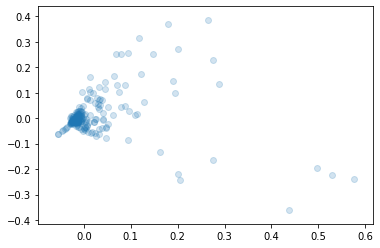

In [23]:
plt.scatter([x[0] for x in X_reduced], [x[1] for x in X_reduced], 
            alpha=0.2);

Selecting a Kernel and Tuning Parameters

In [ ]:
clf = Pipeline([('kpca', KernelPCA(n_components=2)),
                ('log_reg', LogisticRegression())])
param_grid = [{'kpca__gamma': np.linspace(0.3, 0.5, 10),
               'kpca__kernel': ['rbf', 'sigmoid']}]
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)
print(grid_search.best_params)